In [99]:
import pandas as pd
from datetime import datetime, timedelta
import math
import numpy as np
import warnings
from sklearn import linear_model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [100]:
#the players number column, age, weight columns have NaN's in them probably can drop the number and weight columns
#as they are not features 
roster = pd.read_csv('stats_files/rosters', sep = '|')
roster.shape


c:\users\eq5n0fv\envs\prospectmodel\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(136182, 13)

In [101]:
#makes sure age matches this format and removes players which we don't have a birthdate for
#also excludes weird dates that might include dates over 31 or months over 12 or entries of 00
roster = roster[roster['Birthdate'].str.match('(\d\d\d\d)\-((?!00)0[1-9]|1[0-2])\-((?!00)(0[1-9]|[12]\d|3[01]))')]
roster.shape

(136021, 13)

In [102]:
#had two birthdates on september 31st just excluded them 
roster = roster[~roster['Birthdate'].str.match('(\d\d\d\d)\-09\-31')]
roster.shape

(136018, 13)

In [103]:
#Create the season start to calculate age at start of season for age adjusted statistics
roster['season_start'] = roster['season'].apply(lambda x: x - 1).apply('09-15-{}'.format)
roster['Birthdate'] = pd.to_datetime(roster['Birthdate'], format='%Y-%m-%d')
roster['season_start'] = pd.to_datetime(roster['season_start'], format='%m-%d-%Y')
roster['draft_cutoff'] = roster['season'].apply('09-15-{}'.format)
roster['draft_cutoff'] = pd.to_datetime(roster['draft_cutoff'], format='%m-%d-%Y')
#EP lists players Age as their current age instead of the age they were at the season
#I'm calculating their age as the age they are at the draft cutoff of that season
#in order to see if they are draft eligible that season. I have to calculate the players
#at sept. 15th of the draft year for that respective season. I then use that draft
#cutoff age to determine the years from their first draft eligible year
roster['Age'] = (roster['season_start'] - roster['Birthdate'])
roster['Age'] = roster['Age'] / timedelta(days=365)
roster['Age'] = roster['Age'].round(decimals=2)
roster['draft_cutoff_age'] = roster['draft_cutoff'] - roster['Birthdate']
roster['draft_cutoff_age'] = roster['draft_cutoff_age'] / timedelta(days=365)
roster['draft_cutoff_age'] = roster['draft_cutoff_age'].round(decimals=2)

In [104]:
#Remove goalies from the dataframe
roster = roster[roster['Position'] != 'G']
roster['Player'] = roster['Player'].str.strip()

In [105]:
#this function determines the years away from first draft eligible year for the season
#of the row i then apply it to the draft_cutoff_age column using pandas .apply() function
def draft_year(age):
    
    if age >=18 and age < 19:
        return 0
    else:
        return math.floor(age-18)
        
        
roster['draft_year'] = roster['draft_cutoff_age'].apply(draft_year)
#roster.Age.astype

In [106]:
#Join stats dataframe to the main roster dataframe
stats = pd.read_csv('stats_files/player_stats', sep='|')
stats['Player'] = stats['Player'].str.strip()
stats['team'] = stats['team'].str.strip()
stats = stats.groupby(['Player','season', 'team', 'team_id', 'player_id'], as_index=False).sum()

roster = roster.merge(stats[['player_id', 'season', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',  
                           'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-', 'team_id', 'team']], 
                            on = ['player_id', 'season', 'team_id', 'team'])
#new_df[(new_df['team'] == 'Frölunda HC') & (new_df['season']==2018)]

In [107]:

#converting height into decimal values of feet
def clean_height(value):
    '''
    Function to convert height meausered in feet and inches to a decimal
    value
    Input:
    value - height measured in feet and inches
    Output:
    decimal_value - height returned in feet and inches converted to a decimal
                    value of feet
    '''
    try:
        value = value.replace("'", '.').replace(' ', '').replace('"', '')
        value_list = value.split('.')
        value_list[1] = float(value_list[1])/12
        value = float(value_list[0]) + value_list[1]
        value = round(value, 2)
    except IndexError as ex:
        value = ''

    return value

roster['HT'] = roster['HT'].astype('str').apply(clean_height)


In [108]:
#joining league data to the dataframe
leagues_hist = pd.read_csv('stats_files/leagues_hist_table', sep='|')

roster = roster.merge(leagues_hist[['league', 'season', 'team_id']], on=['season', 'team_id'])

In [109]:
#reads in draft data and the NHL stats of each drafted player and then joins it to the 
#master dataframe
nhl_draft_data = pd.read_csv('stats_files/nhl_draft_stats', sep='|')

nhl_draft_data = nhl_draft_data.rename(index=str, columns={'G':'nhl_G', 'GP':'nhl_GP', 'A':'nhl_A', 'TP':'nhl_TP'})
roster = roster.merge(nhl_draft_data[['nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'player_id']], on=['player_id'],
                      how = 'left')
roster = roster.fillna(value=0)

In [110]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

In [111]:
#creating df for age to points regresion stopped at 20 because the regression become negatives as younger players
#graduate to professional leagues
age_adj_score_df = roster[(roster.Age < 20) & (roster.GP >30)]

In [112]:
#splitting into defense and forwards
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

In [113]:
#graphing the correlation between age and points per game 
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

ImportError: matplotlib is required for plotting.

In [114]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)
def_model_yint = round(def_adj_model.intercept_, 3)
fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)
fwd_model_yint = round(fwd_adj_model.intercept_, 3)

In [115]:
#subset main dataframe for only those players in their first draft year and split into forwards and 
#and defnse to calculate age adjusted points per game
draft_year_df = roster[roster['draft_year'] == 0]
draft_year_df_def = draft_year_df[draft_year_df.Position == 'D']
draft_year_df_fwd = draft_year_df[draft_year_df.Position != 'D']

In [116]:
#creating adjusted pts per game for forwards and defense
draft_year_df_def.loc[:,('age_adj_pts_g')] = (1- ((draft_year_df_def.loc[:,('Age')]-17) * def_model_coef)) \
                                        * draft_year_df_def.loc[:,('pts_per_gp')]
draft_year_df_fwd.loc[:,('age_adj_pts_g')] = (1- ((draft_year_df_fwd.loc[:,('Age')]-17) * fwd_model_coef)) \
                                        * draft_year_df_fwd.loc[:,('pts_per_gp')]

#(1 - ([Age as of September of draft year - 17] * 0.1672)) * Pts/GP as from Rhys Jessop formula

c:\users\eq5n0fv\envs\prospectmodel\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\eq5n0fv\envs\prospectmodel\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [117]:
#concatting the fwds and def dataframes back together to form the old draft_year_df dataframe
frames = [draft_year_df_def, draft_year_df_fwd]
draft_year_df = pd.concat(frames)
draft_year_df = draft_year_df.fillna(value=0)

In [118]:
draft_year_df[draft_year_df['Player'] == 'Rasmus Dahlin']


,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,...,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g
102832,26,Rasmus Dahlin,17.44,D,2000-04-13,HC Lidköping,6.17,183,L,310545,...,2,3,SHL,0.0,0,0,0,0.41,0.46,0.449273


In [119]:
#Splitting the data into 80/20 train test split with playing more than 50 games as the feature to predict 
from sklearn.model_selection import train_test_split
draft_year_df['50_plus_nhl_gp'] = np.where(draft_year_df['nhl_GP']>=50, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(draft_year_df[[
                                                                   'GP', 'G', 'A', 'TP',
                                                                   'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP',
                                                                   'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']],
                                                    draft_year_df['50_plus_nhl_gp'], test_size=0.2)

In [120]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7835, 11) (7835,)
(1959, 11) (1959,)


In [121]:
draft_year_df.shape
roster.shape

(120852, 35)

In [122]:
#train the logistic regression
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [123]:
#get probability scores for each player playing over 50 games in NHL
predictions = logisticRegr.predict_proba(X_test)[:,1]


In [124]:
predict = logisticRegr.predict(X_test)

0.9387442572741195

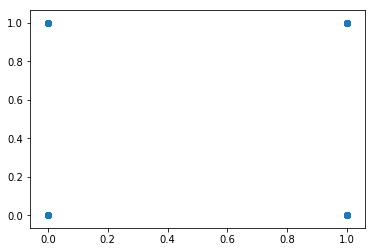

In [125]:
import matplotlib.pyplot as plt
plt.scatter(y_test, predict)
logisticRegr.score(X_test, y_test)

In [126]:
draft_2018_df = draft_year_df[draft_year_df['season']==2018]

In [127]:
draft_2018_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,...,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,50_plus_nhl_gp
25567,47,Filip Andersson,17.77,D,1999-12-14,Smedjebacken HC,6.25,198,L,265669,...,-1,Allsvenskan,0.0,0,0,0,0.00,0.00,0.000000,0
25569,97,Adam Boqvist,17.10,D,2000-08-15,Hedemora SK,5.92,170,R,265684,...,0,Allsvenskan,0.0,0,0,0,0.00,0.29,0.288463,0
25575,71,Jacob Ragnarsson,17.99,D,1999-09-23,SK Iron,6,176,L,304366,...,-1,Allsvenskan,0.0,0,0,0,0.31,0.28,0.265308,0
25713,6,Martin Fehérváry,17.96,D,1999-10-06,SHK Hodonín,6.08,190,L,274991,...,4,Allsvenskan,0.0,0,0,0,0.14,0.17,0.161350,0
25718,47,Christian Lindberg,17.05,D,2000-08-31,Värmdö HC,6.08,161,L,350782,...,1,Allsvenskan,0.0,0,0,0,0.00,0.00,0.000000,0


In [128]:
predictions_2018 = logisticRegr.predict_proba(draft_2018_df[['GP', 'G', 'A', 'TP',
                                                             'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
            
                                                             'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']])[:,1]
predictions = logisticRegr.predict_proba(draft_year_df[['GP', 'G', 'A', 'TP',
                                                             'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
            
                                                             'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']])[:,1]

In [129]:
draft_2018_df['50_game_probs'] = predictions_2018
draft_year_df['50_game_probs'] = predictions


c:\users\eq5n0fv\envs\prospectmodel\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5,0,'NHL GP')

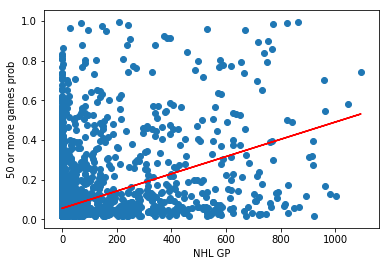

In [130]:
fig, ax = plt.subplots()
fit = np.polyfit(draft_year_df['nhl_GP'], draft_year_df['50_game_probs'], deg=1)
ax.plot(draft_year_df['nhl_GP'], fit[0] * draft_year_df['nhl_GP'] + fit[1], color='red')
ax.scatter(draft_year_df['nhl_GP'], draft_year_df['50_game_probs'])
plt.ylabel('50 or more games prob')
plt.xlabel('NHL GP')

In [131]:
from sklearn.metrics import r2_score
r2_score(draft_year_df['nhl_GP'], draft_year_df['50_game_probs'])

-0.04306691996209944

In [132]:
draft_year_df = draft_year_df.sort_values(['50_game_probs'], ascending=False)

In [98]:
draft_year_df[['Player', '50_game_probs']].head(20)

,Player,50_game_probs
89502,Sidney Crosby,0.995629
86037,Connor McDavid,0.993389
81643,Patrick Kane,0.985696
88926,Alexandre Picard,0.983247
81638,Sam Gagner,0.979986
93846,Jonathan Drouin,0.973070
86742,Matthew Tkachuk,0.972013
86041,Dylan Strome,0.955965
83668,Taylor Hall,0.955165
117037,Nic Petan,0.947610


In [133]:
draft_year_df[draft_year_df['Player']=='Nicklas Bäckström']

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,...,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,50_plus_nhl_gp,50_game_probs
98124,19,Nicklas Bäckström,17.82,C,1987-11-23,Valbo AIF,6,214,L,3682,...,SHL,815.0,209,590,799,0.38,0.57,0.526064,1,0.07773


In [82]:
draft_2018_df[['Player', '50_game_probs']].groupby(['Player'], as_index=False).mean().sort_values(['50_game_probs'], ascending=False).iloc[:50,:]

,Player,50_game_probs
35,Andrei Svechnikov,0.615118
17,Akil Thomas,0.595782
180,Evan Bouchard,0.580972
86,Calen Addison,0.573247
189,Filip Zadina,0.560114
405,Nicolas Beaudin,0.498166
529,Ty Smith,0.492771
416,Oliver Wahlstrom,0.488500
412,Noah Dobson,0.480018
464,Ryan Merkley,0.447345


In [403]:
draft_rankings_2018 = draft_2018_df[['Player', '50_game_probs']].groupby(['Player'], as_index=False).mean().sort_values(['50_game_probs'], ascending=False)

In [412]:
draft_rankings_2018[(draft_rankings_2018['Player']=='Brady Tkachuk')]

,Player,50_game_probs


In [410]:
draft_2018_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,50_plus_nhl_gp,50_game_probs
1875,14,Andrei Svechnikov,17.48,RW,2000-03-26,"Barnaul, RUS",6.25,187,L,328556,865,2018,Barrie Colts,2017-09-15,2018-09-15,18.48,0,44,40,32,72,67,8,5,6,11,12,-1,OHL,0.0,0,0,0,0.56,1.64,1.598278,0,0.664043
3441,11,Filip Zadina,17.81,LW,1999-11-27,"Pardubice, CZE",6.08,192,L,236471,885,2018,Halifax Mooseheads,2017-09-15,2018-09-15,18.81,0,57,44,38,82,36,9,5,7,12,0,2,QMJHL,0.0,0,0,0,0.54,1.44,1.378181,0,0.601278
3427,90,Joseph Veleno,17.68,C,2000-01-13,"Montréal, QC, CAN",6.08,194,L,271713,883,2018,Drummondville Voltigeurs,2017-09-15,2018-09-15,18.68,0,33,16,32,48,22,10,5,6,11,10,-1,QMJHL,0.0,0,0,0,0.33,1.45,1.397742,0,0.574929
1926,44,Akil Thomas,17.72,C,2000-01-02,"Brandon, FL, USA",6,170,R,364033,2231,2018,Niagara IceDogs,2017-09-15,2018-09-15,18.72,0,68,22,59,81,36,10,5,6,11,6,-3,OHL,0.0,0,0,0,0.27,1.19,1.144590,0,0.548598
6306,2,Calen Addison,17.44,D,2000-04-11,"Brandon, MB, CAN",5.83,179,R,278861,793,2018,Lethbridge Hurricanes,2017-09-15,2018-09-15,18.44,0,68,11,54,65,53,16,7,12,19,20,-11,WHL,0.0,0,0,0,0.17,0.96,0.937613,0,0.534190


In [411]:
logisticRegr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [421]:
brady = roster[roster['Player']=='Brady Tkachuk']
brady

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp
77878,27,Brady Tkachuk,18.01,C/LW,1999-09-16,"St. Louis, MO, USA",6.25,196,L,201473,633,2018,Boston Univ.,2017-09-15,2018-09-15,19.01,1,40,8,23,31,61,0,0,0,0,0,0,NCAA,0.0,0,0,0,0.26,0.78
109095,37,Brady Tkachuk,16.01,C/LW,1999-09-16,"St. Louis, MO, USA",6.25,196,L,201473,5156,2016,USNTDP Juniors,2015-09-15,2016-09-15,17.01,-1,32,4,4,8,36,0,0,0,0,0,0,USHL,0.0,0,0,0,0.50,0.25
109643,7,Brady Tkachuk,17.01,C/LW,1999-09-16,"St. Louis, MO, USA",6.25,196,L,201473,5156,2017,USNTDP Juniors,2016-09-15,2017-09-15,18.01,0,24,12,11,23,73,0,0,0,0,0,0,USHL,0.0,0,0,0,0.52,0.96


In [423]:
brady['Birthdate'] - brady['season_start'] 

77878    -6574 days
109095   -5843 days
109643   -6209 days
dtype: timedelta64[ns]

In [450]:
from datetime import datetime
birthday = datetime(1999, 9, 16, 12, 0, 0)
birthday2 = datetime(2017, 9, 13, 12, 0, 0)
print((birthday-birthday2).days/365)

-18.005479452054793


In [460]:
from dateutil.relativedelta import relativedelta
d1 = datetime.strptime('1999-09-16', "%Y-%m-%d")
d2 = datetime.strptime('2017-09-15', "%Y-%m-%d")
rdelta = relativedelta(d2, d1)
print('Age in years - ', rdelta.years)
print('Age in days - ', rdelta.days)
print(rdelta.years + (rdelta.days/365))

Age in years -  17
Age in days -  30
17.08219178082192
